# Optimization For Data Science - Homework

Author: Bach Khoa Tran


---


Email: bachkhoa.tran@studenti.unipd

---


Student ID: 1231699

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import random


%matplotlib inline

# Import and Preprocess Data

In [4]:
ts = pd.read_csv('https://raw.githubusercontent.com/ktran16/datasets/master/train.csv')
ts.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
display(ts.shape)
display(ts.columns)
display(ts.isnull().sum())

(891, 12)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

NOTE:

- Survived is ther target variable. It's a binary classification (1 for alive, 0 for dead)
- Columns 'Age', 'Cabin' and 'Embarked' have missing values
- Columns ' PassengerID', 'Name' and 'Ticket' don't add value in the prediction, so we will drop them out.
- Columns 'Sex', 'Cabin' and 'Embarked' are categorical, so they need to be encoded to numerical values.


In [6]:
# dropping columns
temp = ts
ts.drop(['PassengerId', 'Ticket'], axis = 1, inplace = True)  
display(ts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


None

'ParCh' and 'SibSp' are related to family size, so we create a new column 'family_size'

In [7]:
ts['family_size'] = ts['SibSp'] + ts['Parch'] + 1

Because the 'Name' column has the title, so we extract the title from it and drop the column 'Name'

In [8]:
ts['title'] = ts.Name.str.extract('([A-Za-z]+)\.', expand=False)
ts['title'] = ts['title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Sir', 'Jonkheer', 'Lady', 'Capt', 'Don'], 'Others')
ts['title'] = ts['title'].replace(['Ms', 'Mlle'], 'Miss')
ts['title'] = ts['title'].replace('Mme', 'Mrs')


The 'Cabin' column has a first character which represents the deck number, so we're gonna extract from it

In [9]:
def deck_value(cabin_code):
  if pd.isnull(cabin_code):
    category = 'unknown'
  else:
    category = cabin_code[0]
  return category

deck_number = np.array([deck_value(cabin) for cabin in ts['Cabin'].values])
ts = ts.assign(deck_number = deck_number)

In [10]:
# drop 'Cabin' and 'Name' column 
ts.drop(['Cabin', 'Name'], axis = 1, inplace = True)

Handling missing values in columns: 'Embarked' and 'Age'

In [11]:
# fill NA in 'Embarked' column with the most common
display(ts['Embarked'].value_counts())
display(ts['Embarked'].mode())
ts['Embarked'] = ts['Embarked'].fillna('S')
display(ts['Embarked'].isnull().sum())

S    644
C    168
Q     77
Name: Embarked, dtype: int64

0    S
dtype: object

0

In [12]:
# filling the missing values in 'Age' by mean of age in each group of title
mean_age = ts.groupby('title')['Age'].mean()
list = ['Master', 'Mr', 'Miss', 'Mrs', 'Others']

def age_fillna(mean_age, df, list):
  for title in list:
    temp = df['title'] == title
    df.loc[temp, 'Age'] = df.loc[temp, 'Age'].fillna(mean_age[title])

age_fillna(mean_age, ts, list)

In [13]:
# the dataset is free of missing values
display(ts.isnull().sum())

Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
family_size    0
title          0
deck_number    0
dtype: int64

Encoding categorical columns to numerical values

In [14]:
display(ts.dtypes)

Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
family_size      int64
title           object
deck_number     object
dtype: object

In [15]:
cols = ['Sex', 'Embarked', 'title', 'deck_number']

for i in cols:
  display(i, ts[i].value_counts())

'Sex'

male      577
female    314
Name: Sex, dtype: int64

'Embarked'

S    646
C    168
Q     77
Name: Embarked, dtype: int64

'title'

Mr        517
Miss      185
Mrs       126
Master     40
Others     23
Name: title, dtype: int64

'deck_number'

unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: deck_number, dtype: int64

So we have 4 columns with categorical values: 'Sex', 'Embarked', 'title', 'deck_number'. Instead of assign manually numerical value to each categorical value. We use pd.get_dummies() to avoid bias

In [16]:
ts = pd.get_dummies(ts)
display(ts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
Survived               891 non-null int64
Pclass                 891 non-null int64
Age                    891 non-null float64
SibSp                  891 non-null int64
Parch                  891 non-null int64
Fare                   891 non-null float64
family_size            891 non-null int64
Sex_female             891 non-null uint8
Sex_male               891 non-null uint8
Embarked_C             891 non-null uint8
Embarked_Q             891 non-null uint8
Embarked_S             891 non-null uint8
title_Master           891 non-null uint8
title_Miss             891 non-null uint8
title_Mr               891 non-null uint8
title_Mrs              891 non-null uint8
title_Others           891 non-null uint8
deck_number_A          891 non-null uint8
deck_number_B          891 non-null uint8
deck_number_C          891 non-null uint8
deck_number_D          891 non-null uint8
deck_numb

None

In [0]:
ts_post = ts

Our dataset after cleaning and preprocessing is now free from missiving values, categorical and unneccesary columns althought it increases in dimension size.

# Implement Regularized Logistic Regression

<h2> Regularized Logistic Regression

The cost function of the Regularized Logistic Regression is defined as followed:

![alt text](https://drive.google.com/uc?id=1GDAlrCWfbcCZ4mNkrsf_jdQrdNk6aZq2)

In [17]:
mul = np.dot 
def sigmoid(z):
  return np.power(1 + np.exp(-z), -1)

# theta is the parameter vector
# lambda is the regularization parameter

# hypothesis function
def h(X, theta):
  return sigmoid(mul(X, theta))

# function to initialize theta
def init_theta(X):
  return np.zeros((X.shape[1], 1))

# regularized cost function (by adding lamda)
def j(theta, X, y, lamda):
    m = X.shape[0]
    theta[0] = 0
    if lamda:
      return (-(1/m) * (mul(y.T, np.log(h(X, theta))) + mul((1-y).T, np.log(1 - h(X, theta)))) + 
                (lamda/(2*m))*mul(theta.T, theta))[0][0] 
    return -(1/m) * (mul(y.T, np.log(h(X, theta))) + 
                     mul((1-y).T, np.log(1 - h(X, theta))))[0][0]

Because we have added the regularization term to the cost function, so there will be a change in the derivative of the cost function as followed:

![alt text](https://drive.google.com/uc?id=1CozNGqwrHjUIMObvJ6gybbrRjnEiHsgV)

In [18]:
# regularized cost gradient
def j_prime(theta, X, y, lamda):
  m = X.shape[0]
  theta[0] = 0

  if lamda:
    return (1/m) * mul(X.T, (h(X, theta) - y)) + (lamda/m) * theta 
  return (1/m) * mul(X.T, (h(X, theta) - y)) 


# Implement: Gradient Descent (SD), Stochastic Gradient Descent (SGD) and Stochastic Variance Reduced Gradient (SVRG)


<h2> Gradient Descent for RLR

In [19]:
def GD(X, y, theta, init_alpha, lamda, prev_cost, tolerance):
  alpha = init_alpha  # initialize learning rate alpha
  cost_history = [] # initialize an array to store cost value over iterations
  cost = j(theta, X, y, lamda) # initialize objective function value

  n_epoch = 0
  while(abs(cost - prev_cost) > tolerance): 
    prev_cost = cost
    theta = theta - alpha * j_prime(theta, X, y, lamda)
    cost = j(theta, X, y, lamda)
    cost_history.append(cost)
    n_epoch += 1

  return theta, cost_history, n_epoch

<h2> Stochastic Gradient Descent

The advantage of stochastic gradient is that each step only relies on a single derivative ∇ψi(·), and thus the computational cost is 1/n that of the standard gradient descent.


In [20]:
# function to shuffle data and choose from it randomly - batch_size = 1
def data_iter(X, y):
  n = X.shape[0]
  idx = np.random.randint(0, n)
  X_rand = X[idx, :].reshape(1, X.shape[1]) # generate a random sample X based on rand_ind
  y_rand = y[idx, :].reshape(1, 1) # generate a random target variable sample based on rand_ind
  
  return X_rand, y_rand

In [21]:
def SGD(X, y, init_alpha, lamda, prev_cost, tolerance):
  n, d = X.shape[0], X.shape[1]
  theta = init_theta(X)
  alpha = init_alpha
  cost_history = []
  cost = j(theta, X, y, lamda)
  
  n_epoch = 0
  while(abs(cost - prev_cost) > tolerance):
    prev_cost = cost      
    # cost = 0.0
    for i in range(n):
      X_rand, y_rand = data_iter(X, y)
      theta -= alpha * j_prime(theta, X_rand, y_rand, lamda)
    cost = j(theta, X, y, lamda)
      
    # cost = cost / n  # get the average cost value after randomly picking n times data point from each epoch  
    cost_history.append(cost) # store cost value over epoch
    alpha = alpha/(n + n_epoch)  # decay learning rate alpha after each epoch
    n_epoch += 1
    if n_epoch > 500:
      break

  return theta, cost_history, n_epoch

<h2> Stochastic Variance Reduced Gradient

Stochastic Gradient Descent(SGD) is considered as a good choice. It does not require a huge memory and each of its step is cheap. However, SGD is fast to converge to its local neighborhood rather than the optimal solution. Stochastic Variance Reduced Gradient(a.k.a SVRG) is a recent research work and could be viewed as a modified version of SGD. This algorithm will converge faster to optimal value by reducing the variance.




In [22]:
def SVRG(X, y, init_alpha, lamda, prev_cost, tolerance, theta0=None):
  n, d = X.shape[0], X.shape[1]
       
  # initialize theta     
  if theta0 is None:
    theta = init_theta(X)
  elif isinstance(theta0, np.ndarray) and theta0.shape == (d, ):
    theta = theta0.copy()

  alpha = init_alpha
  cost_history = []
  cost = j(theta, X, y, lamda)
  
  n_epoch = 0
  while(abs(cost - prev_cost) > tolerance):
    prev_cost = cost
    full_grad = j_prime(theta, X, y, lamda)  # full gradient with the previous theta
    theta_tilde = theta.copy() # set theta tilde equal to theta to store the value from previous epoch

    for i in range(n):
      X_rand, y_rand = data_iter(X, y)
      theta -= alpha * (j_prime(theta, X_rand, y_rand, lamda) - j_prime(theta_tilde, X_rand, y_rand, lamda) + full_grad)  # wt = wt−1 − ηt(∇ψit(wt−1) − ∇ψit(w̃) + ∇P(w̃))
      cost = j(theta, X, y, lamda)
    cost_history.append(cost)
    n_epoch += 1

  return theta, cost_history, n_epoch

# Run and Compare 3 Methods

In [23]:
y = ts['Survived'].values
y = np.atleast_2d(y).T

X = ts.drop(['Survived'], axis = 1)
X = X.values

display(X.shape, y.shape)

# normalize X
X_normalized = preprocessing.normalize(X)

(891, 25)

(891, 1)

In [24]:
# initializing the parameters
n, d = X.shape[0], X.shape[1]
theta = init_theta(X) # initialize theta
init_alpha = 0.001 # learning rate
lamda = 1 # regularization parameter
prev_cost = 10000
tolerance = 0.00001

In [27]:
%%time
# run Gradient Descent
theta_gd, cost_history_gd, n_epoch_gd = GD(X_normalized, y, theta, init_alpha, lamda, prev_cost, tolerance)
print('Number of epoch counted until start to converge: {}'.format(n_epoch_gd))

Number of epoch counted until start to converge: 1812
CPU times: user 1.57 s, sys: 36.7 ms, total: 1.6 s
Wall time: 423 ms


In [25]:
%%time
# run SGD
theta_sgd, cost_history_sgd, n_epoch_sgd = SGD(X_normalized, y, init_alpha, lamda, prev_cost, tolerance)
print('Number of epoch counted until start to converge: {}'.format(n_epoch_sgd))

Number of epoch counted until start to converge: 501
CPU times: user 31.6 s, sys: 237 ms, total: 31.9 s
Wall time: 31.5 s


In [26]:
%%time
# run SVRG
theta_svrg, cost_history_svrg, n_epoch_svrg = SVRG(X_normalized, y, init_alpha, lamda, prev_cost, tolerance)
print('Number of epoch counted until start to converge: {}'.format(n_epoch_svrg))

Number of epoch counted until start to converge: 561
CPU times: user 7min 28s, sys: 14.2 s, total: 7min 42s
Wall time: 2min 5s


In [27]:
# Calculate accuracy score of three methods after n_epoch
print('Accuracy score of GD after {} epochs is: {}'.format(n_epoch_gd, accuracy_score(y, np.round(h(X_normalized, theta_gd)))))
print('Accuracy score of SGD after {} epochs is: {}'.format(n_epoch_sgd, accuracy_score(y, np.round(h(X_normalized, theta_sgd)))))
print('Accuracy score of SVRG after {} epochs is: {}'.format(n_epoch_svrg, accuracy_score(y, np.round(h(X_normalized, theta_svrg)))))


Accuracy score of GD after 1812 epochs is: 0.6161616161616161
Accuracy score of SGD after 132 epochs is: 0.6161616161616161
Accuracy score of SVRG after 561 epochs is: 0.6947250280583613


"\nax[1][0].set_title('Stochastic Variance Reduced Gradient')\nax[1][0].set_ylabel('J(Theta)')\nax[1][0].set_xlabel('Number of epoch')\n_=ax[1,0].plot(range(n_epoch_svrg),cost_history_svrg,'b.')\n"

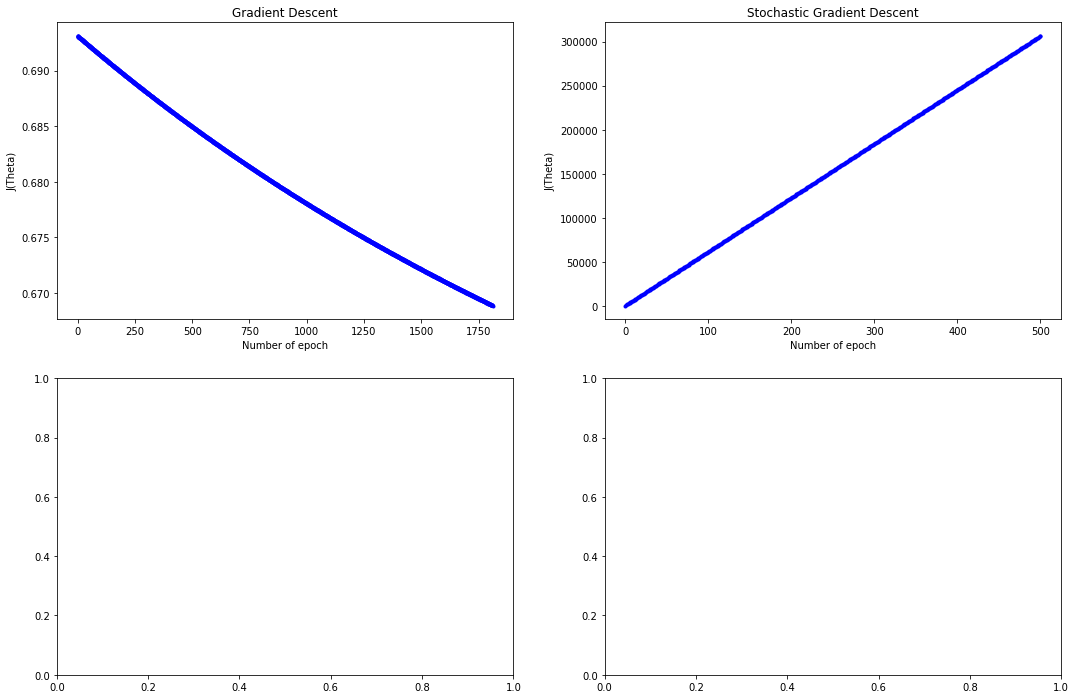

In [28]:
fig,ax = plt.subplots(2, 2, figsize=(18, 12))

ax[0][0].set_title('Gradient Descent')
ax[0][0].set_ylabel('J(Theta)')
ax[0][0].set_xlabel('Number of epoch')
_=ax[0][0].plot(range(n_epoch_gd),cost_history_gd,'b.')

ax[0][1].set_title('Stochastic Gradient Descent')
ax[0][1].set_ylabel('J(Theta)')
ax[0][1].set_xlabel('Number of epoch')
_=ax[0][1].plot(range(n_epoch_sgd),cost_history_sgd,'b.')

'''
ax[1][0].set_title('Stochastic Variance Reduced Gradient')
ax[1][0].set_ylabel('J(Theta)')
ax[1][0].set_xlabel('Number of epoch')
_=ax[1,0].plot(range(n_epoch_svrg),cost_history_svrg,'b.')
'''

## Conclusion

The stopping condition is set to when the current objective function value is greater than the previous value an preset amount (tolerance). From the plot we can see that there're only Gradient Descent (GD) and Stochastic Variance Reduced Gradient (SVRG) converging while Stochastic Gradient Descent (SGD) cannot converge. The reason is because it's highly affected by the randomness when chosing the data point for each estimation. 

In SGD the paramenters are estimated for every observations, as opposed the whole sample in normal gradient descent. That's why it reflects a lot of randomness. Randomness of SGD induces variance of gradient. We can see from the plot that SGD wanders over places and it's more likely to jump out of a local minimum and find a global minium. However, in this case, it is seemingly stuck in a local minimum.

While SVRG still harvest the benefit from higher convegence rate like SGD but it also reduces the variance of stochastic gradient that allows to use a constant learning rate alpha and obtains linear convergene in expectation.

For the computing time, as running in same number of epoch, GD will run fastest, following by SGD and SVRG respectively.
The accuracy acquired by running Regularized Logistic Regression for this dataset is not ideal (very low).

The future work for this exercise can be:
- Find a way to tune the regularized parameter lamda of RLR algorithm
- Tuning learning rate alpha in order to get SG converged
